In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from IPython import display

In [2]:
def gradients(outputs, inputs, order = 1):
    if order == 1:
        return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
    elif order > 1:
        return gradients(gradients(outputs, inputs, 1), inputs, order - 1)
    else:
        return outputs

In [32]:
class ODE(nn.Module):
    def __init__(self):
        super(ODE, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(1, 40),
            nn.GELU(),
            nn.Linear(40, 40),
            nn.GELU(),
            nn.Linear(40, 1),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean = 0, std = 0.1)
                nn.init.constant_(m.bias, val = 0.0)
                
    def forward(self, x):
        return self.net(x) * x * (1 - x) 
    
class ODELoss(nn.Module):
    def __init__(self, ode):
        super(ODELoss, self).__init__()
        self.ode = ode
        
    def forward(self, x):
        f  = self.ode(x)
        df = gradients(f, x, 1)
        d2f = gradients(f, x, 2)
                
        loss = torch.mean((d2f - 5/3*df**2 + 2/3*torch.exp(4*f/3) + 2*torch.exp(37*f/6)*torch.cosh(1/6*f*17**1/2) + 2*torch.exp(17*f/6)*torch.cosh(1/6*f*89**1/2))**2 
                        + (f - 1)**2 + (df)**2)
        
        return loss

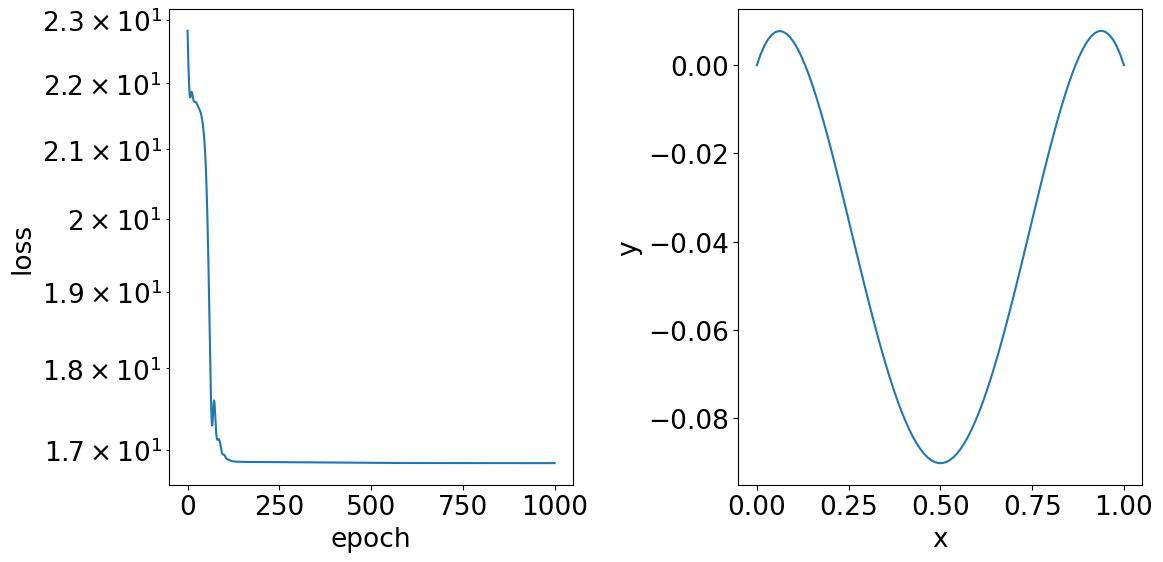

In [33]:
ode = ODE()
odeloss = ODELoss(ode)
loss_hist = []

optimizer = optim.Adam(ode.parameters(), lr=5e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=(0.01)**(1/2000))
x = torch.tensor(np.linspace(0, 1, 100, dtype = np.float32)).reshape(100, 1)
x.requires_grad = True

################## Training and Plotting ##################

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6));
font = {'size'   : 19}
plt.rc('font', **font)

for epoch in range(1001):
    try:
        optimizer.zero_grad()

        loss = odeloss(x)
        loss.backward()
        optimizer.step()

        scheduler.step()
        loss_hist.append(loss.item())

        if epoch % 100 == 0:
            
            
            ax1.cla()
            ax1.set_xlabel('epoch')
            ax1.set_ylabel('loss')
            ax1.set_yscale('log')
            ax1.plot(loss_hist)
            
            ax2.cla()
            ax2.set_xlabel('x')
            ax2.set_ylabel('y')
            ax2.plot(x.cpu().detach().numpy(), ode(x).cpu().detach().numpy())
            
            display.display(plt.gcf())
            display.clear_output(wait=True)
            plt.tight_layout()
            
    except KeyboardInterrupt:
        break
        